In [8]:
import numpy as np
import scipy.io as io
from random import randint
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [9]:
def load_data(filename):
    print('load data...') 
    data = loadmat(filename)
    X = data['data']
    Y = data['info'][0]
    X_train = np.zeros((len(X),X[0,0].shape[1]))
    for i in range(len(X)):
        X_train[i,:]=X[i,0] 
        
    # build word-id dictionary
    with open('dictionary.txt') as f:
        words = [l.strip() for l in f if l.strip()]
    Y_train = np.zeros((360,2))
    
    # preprocess Y train
    for i in range(360):
        Y_train[i,0] = words.index(Y[i]['word'][0])+1 # get the word id from the dictionary
        Y_train[i,1] = randint(1, 60)
        
    return X_train,Y_train,data

In [10]:
Yp = 218
ntrain = 300
ntest = 60
X,wid,data = load_data('data-science-P9.mat')

from sklearn.decomposition import PCA
pca = PCA(n_components=300)
X = pca.fit_transform(X)

dimx = data['meta'][0]['dimx'][0][0][0]
dimy = data['meta'][0]['dimy'][0][0][0]
dimz = data['meta'][0]['dimz'][0][0][0]
visual = np.zeros((dimx,dimy,dimz))

for i in range(X.shape[1]):
    [x,y,z] = data['meta'][0]['colToCoord'][0][i]
    visual[x,y,z]=abs(X[0,i])*255

word_feature=io.mmread('word_feature_centered.mtx')

X_train,X_test,wid_train,wid_test = train_test_split(X,wid,test_size=1/6,random_state=42)

# separate data set
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

# from word id to Y_train (300,1) and Y_test (60,2)
Y_train = np.zeros((ntrain,Yp))
Y_test = np.zeros((ntest,Yp))
Y2_test = np.zeros((ntest,Yp))
for i in range(ntrain):
    for j in range(Yp):
        Y_train[i][j]=word_feature[int(wid_train[i,0])-1][j]
for i in range(ntest):
    for j in range(Yp):
        Y_test[i][j]=word_feature[int(wid_test[i,0])-1][j]
        Y2_test[i][j]=word_feature[int(wid_test[i,1])-1][j]

print('shape of X train:',X_train.shape)
print('shape of X test:',X_test.shape)
print('shape of Y train:',Y_train.shape)
print('shape of Y test:',Y_test.shape)

load data...
shape of X train: (300, 300)
shape of X test: (60, 300)
shape of Y train: (300, 218)
shape of Y test: (60, 218)


visualize part of the activation data

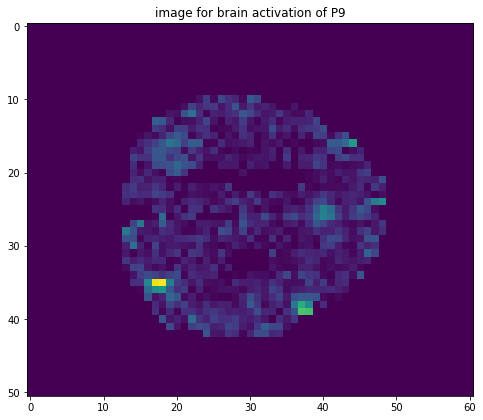

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i in range(20):
    plt.imshow(visual[:,:,i])
plt.title('image for brain activation of P9')
plt.show()

In [11]:
class LassoShooting:
    def __init__(self, X, Y, lamda):
        self.X = X
        self.Y = Y
        self.n = X.shape[0]
        self.p = X.shape[1]
        self.lamda = lamda
        self.w = np.zeros(self.p)
 
    def shoot(self):
        stop=False
        X = self.X
        w = self.w
        t=0
        epsilon=1e-4
        max_iter=20
        while not stop and t<max_iter:
            w_pre = w.copy()
            for j in range(self.p):
                #j = randint(0,self.p-1)
                w_nonj = np.delete(w,j)
                X_nonj = np.delete(X,j,1)  # delete k_th column
                w_j = w[j]*np.ones((self.n,1))
                r_j = X_nonj.dot(w_nonj)-self.Y
                c_j = np.sum(np.multiply(X[:,j],r_j))
                a_j = np.sum(X[:,j]**2)
                if c_j > self.lamda:
                    w[j] = (-c_j+self.lamda)/a_j
                elif c_j < (-self.lamda):
                    w[j] = (-c_j-self.lamda)/a_j
                else:
                    w[j] = 0  
            if max(abs(w-w_pre))<=epsilon:
                stop=True
            t+=1    
        self.w =w         
    
    def predict(self,X,w):
        return X.dot(w)

In [12]:
def L1(pred,y_true,y_wrong):
    score = 0
    for i in range(len(pred)):
        d1 = np.sum(np.abs(pred[i]-y_true[i]))
        d2 = np.sum(np.abs(pred[i]-y_wrong[i]))
        if d1<d2:
            score+=1
        elif d1==d2:
            score+=0.5
    return score
    
def L2(pred,y_true,y_wrong):
    score = 0
    for i in range(len(pred)):
        d1 = np.sum((pred[i]-y_true[i])**2)
        d2 = np.sum((pred[i]-y_wrong[i])**2)
        if d1<d2:
            score+=1
        elif d1==d2:
            score+=0.5
    return score

train the model

In [13]:
weight = np.zeros((X_train.shape[1],Y_train.shape[1]))
for j in range(Yp):
    # print(j)
    ls = LassoShooting(X_train,Y_train[:,j],0.15)
    ls.shoot()
    weight[:,j]=ls.w
y_hat = ls.predict(X_test,weight)

print test results

In [14]:
print('---------The 9th Person--------')
print('Accuracy for L1:',L1(y_hat,Y_test,Y2_test)/len(Y_test))
print('Accuracy for L2:',L2(y_hat,Y_test,Y2_test)/len(Y_test))

---------The 9th Person--------
Accuracy for L1: 0.7416666666666667
Accuracy for L2: 0.725
